## Workshop 2: Image Classification

Geoprocesamiento 2025-1S  
Universidad Nacional de Colombia

### Import modules

In [1]:
# Import modules from python standard library
import os
import pprint
import random

# Import Geopandas for vector analysis (https://geopandas.org)
import geopandas

# Import the matplotlib plotting module and set it to work within
# a notebook environment.
%matplotlib inline
import matplotlib
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt

# Import the RSGISLib modules for the notebook
import rsgislib
import rsgislib.classification
import rsgislib.classification.classsklearn
import rsgislib.tools.filetools
import rsgislib.tools.mapping
import rsgislib.tools.plotting
import rsgislib.vectorutils
import rsgislib.zonalstats
from sklearn.ensemble import RandomForestClassifier

# scikit-learn imports
from sklearn.model_selection import GridSearchCV

In [23]:
import rasterio
from shapely.geometry import box

Read Sentinel-2 images

In [3]:
# Input Sentinel-2 image file with 20 m resolution pixels.
input_img = "notebooks/Taller2/image_export3.tif"

in_msk_img = "notebooks/Data_geoprocessing/sen2_20180629_t30uvd_orb037_osgb_stdsref_20m_vmsk.tif" # Está igual que el workshop (cambiar luego)

vec_train_file = "notebooks/Data_geoprocessing/data/Datos_alternos.gpkg" 

In [4]:
with rasterio.open(input_img) as src:
    print("Raster CRS:", src.crs)

Raster CRS: EPSG:32618


In [37]:
lyr_names = rsgislib.vectorutils.get_vec_lyrs_lst(vec_train_file)
print(lyr_names )

['Amazontraining', 'Andestraining', 'AmazonTesting', 'AndesTesting', 'AndesTraining_']


Read Andes Testing layer

In [38]:
andes_test= geopandas.read_file(vec_train_file, layer=lyr_names[3])
andes_test = andes_test.to_crs("EPSG:32618")
andes_test.head()

,Classified,Reference,geometry
0,1,1,POINT (331911.701 383932.977)
1,1,1,POINT (721833.326 620077.725)
2,1,1,POINT (332629.07 383127.267)
3,1,1,POINT (433824.813 690458.95)
4,1,1,POINT (335469.699 434555.038)


Read Andes Training layer

In [39]:
andes_train= geopandas.read_file(vec_train_file, layer=lyr_names[1])
andes_train = andes_train.to_crs("EPSG:32618")
andes_train.head()

,Name,description,timestamp,begin,end,altitudeMode,tessellate,extrude,visibility,drawOrder,icon,landcover,system_index,geometry
0,Artificial surfaces,None,NaT,NaT,NaT,None,-1,0,-1,NaN,None,0,0000000000000000062b,"POLYGON ((706129.477 789432.95, 706362.979 789..."
1,Artificial surfaces,None,NaT,NaT,NaT,None,-1,0,-1,NaN,None,0,0000000000000000062c,"POLYGON ((705916.441 789731.462, 706003.139 78..."
2,Artificial surfaces,None,NaT,NaT,NaT,None,-1,0,-1,NaN,None,0,0000000000000000062d,"POLYGON ((707286.357 788660.84, 707616.918 788..."
3,Artificial surfaces,None,NaT,NaT,NaT,None,-1,0,-1,NaN,None,0,0000000000000000062e,"POLYGON ((706249.975 788508.182, 706611.568 78..."
4,Artificial surfaces,None,NaT,NaT,NaT,None,-1,0,-1,NaN,None,0,0000000000000000062f,"POLYGON ((702267.912 785424.558, 702420.637 78..."


In [40]:
print(len(andes_train))
print(andes_train.geom_type.unique())
print(andes_train["Name"].unique())  # Check name of classes
print(andes_train["Name"].value_counts())  # Check number of samples per class

2086
['Polygon' 'Point' 'LineString']
['Artificial surfaces' 'Agricultural areas' 'Forest'
 'Shrub or herbaceous vegetation' 'sparsely or no vegetated areas'
 'Water bodies' 'Secondary vegetation' 'Clouds' 'Shadow' 'Ice and snow']
Name
Agricultural areas                408
sparsely or no vegetated areas    273
Artificial surfaces               203
Water bodies                      202
Shrub or herbaceous vegetation    200
Forest                            200
Secondary vegetation              200
Ice and snow                      200
Clouds                            100
Shadow                            100
Name: count, dtype: int64


Read Andes Training_ layer (2)

In [41]:
andes_train2= geopandas.read_file(vec_train_file, layer=lyr_names[4])
andes_train2 = andes_train2.to_crs("EPSG:32618")
andes_train2.head()

,Name,description,timestamp,begin,end,altitudeMode,tessellate,extrude,visibility,drawOrder,icon,landcover,system_index,geometry
0,Artificial surfaces,None,NaT,NaT,NaT,None,-1,0,-1,NaN,None,0,0000000000000000062b,"POLYGON ((706129.477 789432.95, 706362.979 789..."
1,Artificial surfaces,None,NaT,NaT,NaT,None,-1,0,-1,NaN,None,0,0000000000000000062c,"POLYGON ((705916.441 789731.462, 706003.139 78..."
2,Artificial surfaces,None,NaT,NaT,NaT,None,-1,0,-1,NaN,None,0,0000000000000000062d,"POLYGON ((707286.357 788660.84, 707616.918 788..."
3,Artificial surfaces,None,NaT,NaT,NaT,None,-1,0,-1,NaN,None,0,0000000000000000062e,"POLYGON ((706249.975 788508.182, 706611.568 78..."
4,Artificial surfaces,None,NaT,NaT,NaT,None,-1,0,-1,NaN,None,0,0000000000000000062f,"POLYGON ((702267.912 785424.558, 702420.637 78..."


In [43]:
print(len(andes_train2))
print(andes_train2.geom_type.unique())
print(andes_train2["Name"].unique())  # Check name of classes
print(andes_train2["Name"].value_counts())  # Check number of samples per class

2103
['Polygon' 'Point' 'LineString']
['Artificial surfaces' 'Agricultural areas' 'Forest'
 'Shrub or herbaceous vegetation' 'sparsely or no vegetated areas'
 'Water bodies' 'Secondary vegetation' 'Clouds' 'Shadow' 'Ice and snow']
Name
Agricultural areas                425
sparsely or no vegetated areas    273
Artificial surfaces               203
Water bodies                      202
Shrub or herbaceous vegetation    200
Forest                            200
Secondary vegetation              200
Ice and snow                      200
Clouds                            100
Shadow                            100
Name: count, dtype: int64


Read Amazon Training layer

In [42]:
ama_train= geopandas.read_file(vec_train_file, layer=lyr_names[0])
ama_train = ama_train.to_crs("EPSG:32618")
ama_train.head()

,Name,description,timestamp,begin,end,altitudeMode,tessellate,extrude,visibility,drawOrder,icon,landcover,system_index,geometry
0,Artificial_surfaces,None,NaT,NaT,NaT,None,-1,0,-1,NaN,None,0,000000000000000002e7,"POLYGON ((333427.151 55005.844, 333575.057 550..."
1,Artificial_surfaces,None,NaT,NaT,NaT,None,-1,0,-1,NaN,None,0,000000000000000002e8,"POLYGON ((333098.509 54737.215, 333185.866 547..."
2,Artificial_surfaces,None,NaT,NaT,NaT,None,-1,0,-1,NaN,None,0,000000000000000002e9,"POLYGON ((333095.169 55333.793, 333243.572 553..."
3,Artificial_surfaces,None,NaT,NaT,NaT,None,-1,0,-1,NaN,None,0,000000000000000002ea,"POLYGON ((333848.547 55036.815, 334055.023 550..."
4,Artificial_surfaces,None,NaT,NaT,NaT,None,-1,0,-1,NaN,None,0,000000000000000002eb,"POLYGON ((320156.968 113863.94, 320305.856 113..."


In [44]:
print(len(andes_train))
print(ama_train.geom_type.unique())
print(ama_train["Name"].unique())  # Check name of classes
print(ama_train["Name"].value_counts())  # Check number of samples per class


2086
['Polygon' 'LineString' 'Point']
['Artificial_surfaces' 'Agricultural_areas' 'Forest'
 'Shurb_and_herbaceous' 'Sparsely_or_no_vegetated areas' 'Water_bodies'
 'Secondary_vegetation' 'Clouds' 'sparsely or no vegetated areas']
Name
Forest                            381
Artificial_surfaces               204
Secondary_vegetation              202
Sparsely_or_no_vegetated areas    200
Agricultural_areas                200
sparsely or no vegetated areas    200
Water_bodies                      200
Shurb_and_herbaceous              189
Clouds                            171
Name: count, dtype: int64


Join Andes and Amazon Training layers

In [45]:
import pandas as pd
import geopandas as gpd

# Concatenate (stack) them together
andes_ama_concat = pd.concat([andes_train, ama_train, andes_train2], ignore_index=True)
andes_ama_concat = gpd.GeoDataFrame(andes_ama_concat, geometry='geometry', crs=andes_train.crs)

In [46]:
andes_ama_concat

,Name,description,timestamp,begin,end,altitudeMode,tessellate,extrude,visibility,drawOrder,icon,landcover,system_index,geometry
0,Artificial surfaces,None,NaT,NaT,NaT,None,-1,0,-1,NaN,None,0,0000000000000000062b,"POLYGON ((706129.477 789432.95, 706362.979 789..."
1,Artificial surfaces,None,NaT,NaT,NaT,None,-1,0,-1,NaN,None,0,0000000000000000062c,"POLYGON ((705916.441 789731.462, 706003.139 78..."
2,Artificial surfaces,None,NaT,NaT,NaT,None,-1,0,-1,NaN,None,0,0000000000000000062d,"POLYGON ((707286.357 788660.84, 707616.918 788..."
3,Artificial surfaces,None,NaT,NaT,NaT,None,-1,0,-1,NaN,None,0,0000000000000000062e,"POLYGON ((706249.975 788508.182, 706611.568 78..."
4,Artificial surfaces,None,NaT,NaT,NaT,None,-1,0,-1,NaN,None,0,0000000000000000062f,"POLYGON ((702267.912 785424.558, 702420.637 78..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6131,Ice and snow,None,NaT,NaT,NaT,None,-1,0,-1,NaN,None,11,000000000000000002e9,"POLYGON ((465218.73 540715.498, 465571.736 540..."
6132,Ice and snow,None,NaT,NaT,NaT,None,-1,0,-1,NaN,None,11,000000000000000002ea,"POLYGON ((465597.938 540713.351, 465747.737 54..."
6133,Ice and snow,None,NaT,NaT,NaT,None,-1,0,-1,NaN,None,11,000000000000000002eb,"POLYGON ((465569.122 540419.098, 465927.563 54..."
6134,Ice and snow,None,NaT,NaT,NaT,None,-1,0,-1,NaN,None,11,000000000000000002ec,"POLYGON ((464942.185 540333.132, 465180.481 54..."


In [47]:
print(len(andes_ama_concat))
print(andes_ama_concat["Name"].unique())  # Check name of classes
print(andes_ama_concat.geom_type.unique())
print(andes_ama_concat["Name"].value_counts())  # Check number of samples per class
print(andes_ama_concat.crs)

6136
['Artificial surfaces' 'Agricultural areas' 'Forest'
 'Shrub or herbaceous vegetation' 'sparsely or no vegetated areas'
 'Water bodies' 'Secondary vegetation' 'Clouds' 'Shadow' 'Ice and snow'
 'Artificial_surfaces' 'Agricultural_areas' 'Shurb_and_herbaceous'
 'Sparsely_or_no_vegetated areas' 'Water_bodies' 'Secondary_vegetation']
['Polygon' 'Point' 'LineString']
Name
Agricultural areas                833
Forest                            781
sparsely or no vegetated areas    746
Artificial surfaces               406
Water bodies                      404
Shrub or herbaceous vegetation    400
Secondary vegetation              400
Ice and snow                      400
Clouds                            371
Artificial_surfaces               204
Secondary_vegetation              202
Shadow                            200
Agricultural_areas                200
Sparsely_or_no_vegetated areas    200
Water_bodies                      200
Shurb_and_herbaceous              189
Name: count, dtyp

In [48]:
# Get the full image bounding box.
img_bbox = rsgislib.imageutils.get_img_bbox(input_img)
print(img_bbox)

(399940.0, 509760.0, 90250.0, 200050.0)


In [49]:
# img_bbox should be [minx, maxx, miny, maxy]
minx, maxx, miny, maxy = img_bbox
bbox_geom = box(399940.0, 90250.0, 470000.0, 200050.0)

andes_ama_train_clipped = geopandas.clip(andes_ama_concat, bbox_geom)
# Now andes_ama_train_clipped contains only features within the bounding box
# You can display or use it as needed
andes_ama_train_clipped

,Name,description,timestamp,begin,end,altitudeMode,tessellate,extrude,visibility,drawOrder,icon,landcover,system_index,geometry
2457,Agricultural_areas,None,NaT,NaT,NaT,None,-1,0,-1,NaN,None,1,00000000000000000560,"POLYGON ((416244.734 103224.283, 416546.405 10..."
2325,Agricultural_areas,None,NaT,NaT,NaT,None,-1,0,-1,NaN,None,1,00000000000000000386,"POLYGON ((429108.199 106321.075, 429829.591 10..."
2416,Agricultural_areas,None,NaT,NaT,NaT,None,-1,0,-1,NaN,None,1,00000000000000000537,"POLYGON ((412259.527 111711.636, 412379.107 11..."
2417,Agricultural_areas,None,NaT,NaT,NaT,None,-1,0,-1,NaN,None,1,00000000000000000538,"POLYGON ((412437.149 111683.496, 412616.753 11..."
3662,Clouds,None,NaT,NaT,NaT,None,-1,0,-1,NaN,None,7,0000000000000000012e,"POLYGON ((416722.827 115465.559, 416786.329 11..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5358,Secondary vegetation,None,NaT,NaT,NaT,None,-1,0,-1,NaN,None,6,0000000000000000032d,"POLYGON ((445945.742 193031.126, 446007.745 19..."
257,Agricultural areas,None,NaT,NaT,NaT,None,-1,0,-1,NaN,None,1,000000000000000006af,"POLYGON ((456904.266 193115.816, 457013.374 19..."
4278,Agricultural areas,None,NaT,NaT,NaT,None,-1,0,-1,NaN,None,1,000000000000000006af,"POLYGON ((456904.266 193115.816, 457013.374 19..."
256,Agricultural areas,None,NaT,NaT,NaT,None,-1,0,-1,NaN,None,1,000000000000000006ae,"POLYGON ((451971.519 198093.045, 452303.312 19..."


In [50]:
print(len(andes_ama_train_clipped))
print(andes_ama_train_clipped["Name"].unique())  # Check name of classes
print(andes_ama_train_clipped.geom_type.unique())
print(andes_ama_train_clipped["Name"].value_counts())  # Check number of samples per class
print(andes_ama_train_clipped.crs)

132
['Agricultural_areas' 'Clouds' 'Water_bodies' 'Artificial_surfaces'
 'Agricultural areas' 'Secondary vegetation']
['Polygon' 'Point']
Name
Artificial_surfaces     74
Agricultural areas      23
Agricultural_areas      17
Secondary vegetation     8
Clouds                   6
Water_bodies             4
Name: count, dtype: int64
EPSG:32618


In [51]:
andes_ama_train_clipped.to_file("notebooks/Taller2/andes_ama_train_clip2.gpkg", driver="GPKG")

In [52]:
andes_ama_clip_cloud= geopandas.read_file(r'notebooks/Taller2/andes_ama_train_clip.gpkg')
andes_ama_clip_cloud

,Name,description,timestamp,begin,end,altitudeMode,tessellate,extrude,visibility,drawOrder,icon,landcover,system_index,geometry
0,Agricultural_areas,None,NaT,NaT,NaT,None,-1,0,-1,NaN,None,1,00000000000000000560,"POLYGON ((416244.734 103224.283, 416546.405 10..."
1,Agricultural_areas,None,NaT,NaT,NaT,None,-1,0,-1,NaN,None,1,00000000000000000386,"POLYGON ((429108.199 106321.075, 429829.591 10..."
2,Agricultural_areas,None,NaT,NaT,NaT,None,-1,0,-1,NaN,None,1,00000000000000000537,"POLYGON ((412259.527 111711.636, 412379.107 11..."
3,Agricultural_areas,None,NaT,NaT,NaT,None,-1,0,-1,NaN,None,1,00000000000000000538,"POLYGON ((412437.149 111683.496, 412616.753 11..."
4,Clouds,None,NaT,NaT,NaT,None,-1,0,-1,NaN,None,7,0000000000000000012e,"POLYGON ((445181.744 189210.266, 445181.713 18..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127,Secondary vegetation,None,NaT,NaT,NaT,None,-1,0,-1,NaN,None,6,0000000000000000032d,"POLYGON ((445945.742 193031.126, 446007.745 19..."
128,Agricultural areas,None,NaT,NaT,NaT,None,-1,0,-1,NaN,None,1,000000000000000006af,"POLYGON ((456904.266 193115.816, 457013.374 19..."
129,Agricultural areas,None,NaT,NaT,NaT,None,-1,0,-1,NaN,None,1,000000000000000006af,"POLYGON ((456904.266 193115.816, 457013.374 19..."
130,Agricultural areas,None,NaT,NaT,NaT,None,-1,0,-1,NaN,None,1,000000000000000006ae,"POLYGON ((451971.519 198093.045, 452303.312 19..."


In [53]:
print(len(andes_ama_clip_cloud))
print(andes_ama_clip_cloud["Name"].unique())  # Check name of classes
print(andes_ama_clip_cloud.geom_type.unique())
print(andes_ama_clip_cloud["Name"].value_counts())  # Check number of samples per class
print(andes_ama_clip_cloud.crs)

132
['Agricultural_areas' 'Clouds' 'Water_bodies' 'Artificial_surfaces'
 'Agricultural areas' 'Secondary vegetation']
['Polygon' 'Point']
Name
Artificial_surfaces     74
Agricultural areas      23
Agricultural_areas      17
Secondary vegetation     8
Clouds                   6
Water_bodies             4
Name: count, dtype: int64
EPSG:32618


In [54]:
andes_ama_clip_cloud['Name'] = andes_ama_clip_cloud['Name'].replace({
    'Agricultural areas': 'Agricultural areas',
    'Agricultural_areas': 'Agricultural areas'
})
print(andes_ama_clip_cloud["Name"].unique()) 
categorias_unicas = andes_ama_clip_cloud["Name"].unique()

['Agricultural areas' 'Clouds' 'Water_bodies' 'Artificial_surfaces'
 'Secondary vegetation']


In [55]:
# Iterar sobre cada valor único y exportar como una capa separada
for categoria in categorias_unicas:
    # Filtrar el GeoDataFrame por la categoría actual
    andes_ama_train = andes_ama_clip_cloud[andes_ama_clip_cloud['Name'] == categoria]
    
    # Definir el nombre de la capa (puedes ajustar según tus necesidades)
    nombre_capa = str(categoria).replace(' ', '_').lower()
    
    # Escribir la capa en el GeoPackage
    andes_ama_train.to_file(r'notebooks/Taller2/andes_ama_train_final.gpkg', layer=nombre_capa, driver='GPKG', mode='a')

The following cell creates a single map that overlays our **Sentinel-2 composite** with the **training points/polygons**. The aim is to confirm that every sample truly sits on its intended land-cover type.

* **Bounding box**  
Clip the display to `sub_img_bbox = [275 000, 300 000, 275 000, 300 000]` (min-x, max-x, min-y, max-y in OSGB metres). This 25 km × 25 km window keeps the figure concise while covering all training layers.

* **Base image (bands 8-9-3)**  
  `rsgislib.tools.mapping.create_raster_img_map` draws a pseudo-RGB composite using Sentinel-2 bands 8 (NIR), 9 (red-edge) and 3 (green). A cumulative-histogram stretch enhances local contrast and a scale bar is added automatically.

* **Random colours for each land-cover class**  
  Pull Matplotlib’s full CSS4 palette (`mcolors.CSS4_COLORS`) and assign a different random hue to every layer listed in **`lyr_names`**. This guarantees that classes are visually distinct without the tedium of manual colour picking.

* **Loading the training layers**  
  Each layer from `vec_train_file` (GeoPackage/ShapeFile) is read into a GeoPandas `GeoDataFrame`, then stored in `gp_vecs`, ready for plotting.

* **Vector overlay**  
  `create_vec_lyr_map` draws all training layers in one command, using the randomly chosen fill colours and a thin black outline. The bounding box ensures the overlay matches the raster subset perfectly; the second scale-bar is suppressed to avoid clutter.

**Why do this?**  
Before running any machine-learning routine we need to be certain that:

1. The image subset genuinely covers every training point.  
2. No sample falls on clouds, edge artefacts, or outside the valid-pixel mask.  
3. The spectral composite looks sensible (no band shifts, correct stretch).

A quick glance at this figure can save a lot of wasted processing time later on.

> **🔍  experiment with band combinations:**  
> Change `img_bands=[8, 9, 3]` to another trio—e.g. `[11, 8, 4]` (SWIR-NIR-Red) or `[12, 11, 4]`—and observe how vegetation, built-up areas and water bodies respond. 

In geopandas.read_file, the layer argument tells GeoPandas which vector layer inside the file to load. A Shapefile holds only one layer, so layer= is ignored.

A GeoPackage (.gpkg) or MapInfo TAB can store several layers—effectively multiple datasets in a single container. You therefore have to specify which one you want.
In this notebook, lyr_names is a list of strings, each string being the exact name of a class-specific layer in vec_train_file

Image Data Size: 7006 x 10980


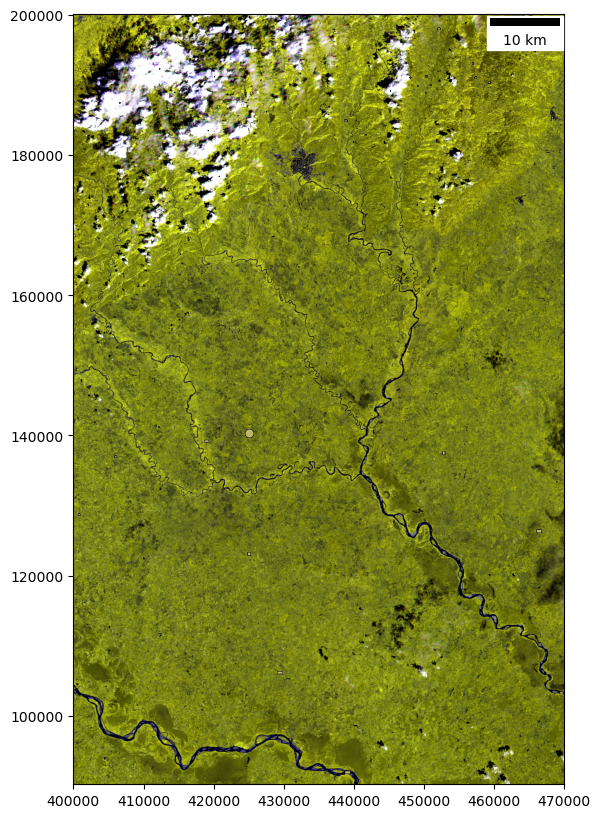

In [32]:
# 1. Define the map window using four OSGB coordinates: xmin, xmax, ymin, ymax (metres).
sub_img_bbox = [399940.0, 470000.0, 90250.0, 200050.0]
# ---------------------------------------------------------
# 2. Prepare a Matplotlib canvas
#    One axis, 10 × 10 inches – large enough for legible detail.
fig, ax = plt.subplots(figsize=(10, 10))
# ---------------------------------------------------------
# 3. Draw a Sentinel-2 RGB composite
#    * input_img       : full multispectral stack
#    * img_bands       : [8 (NIR), 9 (red-edge), 3 (green)]
#    * img_stch        : cumulative histogram stretch for contrast
#    * bbox            : clip to the subset
#    * show_scale_bar  : adds a 5 km bar bottom-left
# ---------------------------------------------------------
rsgislib.tools.mapping.create_raster_img_map(
    ax,
    input_img,
    img_bands=[8, 9, 3],
    img_stch=rsgislib.IMG_STRETCH_CUMULATIVE,
    bbox=sub_img_bbox,
    show_scale_bar=True,
)

# ---------------------------------------------------------
# 4. Build a palette of distinct colours
#    CSS4 provides ~140 named colours; we convert the dict keys
#    to a list so random.choice can pick from it.
mpl_clrs = list(mcolors.CSS4_COLORS.keys())

# Lists to store GeoPandas layers and their display colours
gp_vecs  = []
lyr_clrs = []

# ---------------------------------------------------------
# 5. Load each training layer and assign a random colour
#    * lyr_names        : list of class layers in the GeoPackage
#    * vec_train_file   : path to the training samples (GPKG)
for lyr_name in lyr_names:
    # Read the class layer as a GeoDataFrame
    gp_vecs.append(andes_ama_clip_cloud)
    # Pick a random CSS colour to fill that class
    lyr_clrs.append(random.choice(mpl_clrs))

# ---------------------------------------------------------
# 6. Overlay the training vectors on the RGB image
#    * gp_vecs         : list of GeoDataFrames (one per class)
#    * vec_fill_clrs   : matching list of fill colours
#    * vec_line_clrs   : outline colour (“black” for all)
#    * bbox            : ensures vectors are clipped to the subset
#    * show_scale_bar  : False – we already drew one above
# ---------------------------------------------------------
rsgislib.tools.mapping.create_vec_lyr_map(
    ax,
    gp_vecs=gp_vecs,
    bbox=sub_img_bbox,
    vec_fill_clrs=lyr_clrs,
    vec_line_clrs="black",
    show_scale_bar=False,
)


Extract training samples

Define images and bands for classification

In [35]:
img_band_info = list()
img_band_info.append(
    rsgislib.imageutils.ImageBandInfo(
        file_name=input_img, name="sen2", bands=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
    )
)
print(img_band_info)

[('sen2', [1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 'notebooks/Taller2/image_export3.tif')]


In [59]:
lyr_names2 = rsgislib.vectorutils.get_vec_lyrs_lst(r'notebooks/Taller2/andes_ama_train_final.gpkg')
print(lyr_names2 )


['agricultural_areas', 'clouds', 'water_bodies', 'artificial_surfaces', 'secondary_vegetation']


Define the class and the vector samples

In [60]:
class_vec_sample_info = list()

# Define the file name of the samples HDF5 file, which will be created
agricultural_areas_h5 = "notebooks/Taller2/h5/agricultural_areas_smpls.h5"
class_vec_sample_info.append(
    rsgislib.classification.ClassVecSamplesInfoObj(
        id=1,
        class_name="agricultural_areas",
        vec_file=andes_ama_train,
        vec_lyr="agricultural_areas",
        file_h5=agricultural_areas_h5,
    )
)

# Define the file name of the samples HDF5 file, which will be created
clouds_h5 = "notebooks/Taller2/h5/clouds_smpls.h5"
class_vec_sample_info.append(
    rsgislib.classification.ClassVecSamplesInfoObj(
        id=2,
        class_name="clouds",
        vec_file=andes_ama_train,
        vec_lyr="clouds",
        file_h5=clouds_h5,
    )
)


# Define the file name of the samples HDF5 file, which will be created
water_bodies_h5 = "notebooks/Taller2/h5/water_bodies_smpls.h5"
class_vec_sample_info.append(
    rsgislib.classification.ClassVecSamplesInfoObj(
        id=3,
        class_name="water_bodies",
        vec_file=andes_ama_train,
        vec_lyr="water_bodies",
        file_h5=water_bodies_h5,
    )
)


# Define the file name of the samples HDF5 file, which will be created
artificial_surfaces_h5 = "notebooks/Taller2/h5/artificial_surfaces_smpls.h5"
class_vec_sample_info.append(
    rsgislib.classification.ClassVecSamplesInfoObj(
        id=4,
        class_name="artificial_surfaces",
        vec_file=andes_ama_train,  #vec_train_file
        vec_lyr="artificial_surfaces",
        file_h5=artificial_surfaces_h5,
    )
)

# Define the file name of the samples HDF5 file, which will be created
secondary_vegetation_h5 = "notebooks/Taller2/h5/secondary_vegetation_smpls.h5"
class_vec_sample_info.append(
    rsgislib.classification.ClassVecSamplesInfoObj(
        id=5,
        class_name="secondary_vegetation",
        vec_file=andes_ama_train,
        vec_lyr="secondary_vegetation",
        file_h5=secondary_vegetation_h5,
    )
)


## See what is inside  class_vec_sample_info
print(class_vec_sample_info)

[<rsgislib.classification.ClassVecSamplesInfoObj object at 0x7f5d66ae5bd0>, <rsgislib.classification.ClassVecSamplesInfoObj object at 0x7f5d66ae5ed0>, <rsgislib.classification.ClassVecSamplesInfoObj object at 0x7f5d5dad6f10>, <rsgislib.classification.ClassVecSamplesInfoObj object at 0x7f5d5dad4c10>, <rsgislib.classification.ClassVecSamplesInfoObj object at 0x7f5d5dad5650>]
